In [77]:
import numpy as np
import pandas as pd
import os
import random
from skimage import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [79]:
# Constants
img_width = 128
img_height = 128
img_size = (img_width, img_height)
img_channels = 3
batch_size = 15
num_epochs = 10

In [80]:
# Dataset class
class DogCatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(image_path)
        label = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations

In [81]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [82]:
val_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and preprocess data

In [83]:
train_directory = "data/dogs-vs-cats/train"
image_files = os.listdir(train_directory)

In [84]:
categories = [1 if img_name.split('.')[0] == "dog" else 0 for img_name in image_files]

In [85]:
df = pd.DataFrame({
    'image_name': image_files,
    'category': categories
})
df.head(5)

,image_name,category
0,dog.8659.jpg,1
1,cat.4935.jpg,0
2,cat.9291.jpg,0
3,cat.10060.jpg,0
4,dog.4013.jpg,1


In [86]:
# Split data
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [87]:
# Create Datasets and DataLoaders
train_dataset = DogCatDataset(train_df, train_directory, transform=train_transform)
validate_dataset = DogCatDataset(validate_df, train_directory,transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

In [88]:
# Visualize some images after transformations
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

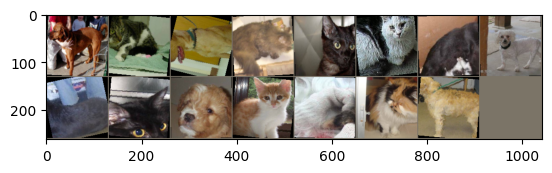

    1     0     1     0     0     0     0     1     1     0     1     0     0     0     1


In [89]:
from torchvision.utils import make_grid
import torchvision

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(make_grid(images))
print(' '.join('%5s' % labels[j].item() for j in range(len(labels))))

# Model definition

In [90]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.Linear(512, 2)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [91]:
model = SimpleCNN().to(device)

In [92]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5, min_lr=0.00001)

# Train and validate the model

In [93]:
from tqdm import tqdm

def train_model(model, train_loader, validate_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Update progress bar
            progress_bar.set_postfix(loss=running_loss/len(train_loader.dataset), acc=running_corrects.double()/len(train_loader.dataset))

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        val_loss, val_acc = validate_model(model, validate_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())
        scheduler.step(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

def validate_model(model, validate_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    val_loss = running_loss / len(validate_loader.dataset)
    val_acc = running_corrects.double() / len(validate_loader.dataset)
    return val_loss, val_acc

Epoch 1/10, Train Loss: 0.6784, Train Acc: 0.5915, Val Loss: 0.9119, Val Acc: 0.6490


Epoch 2/10, Train Loss: 0.6404, Train Acc: 0.6366, Val Loss: 0.9022, Val Acc: 0.6254


Epoch 3/10, Train Loss: 0.6111, Train Acc: 0.6672, Val Loss: 1.7646, Val Acc: 0.6914


Epoch 4/10, Train Loss: 0.6027, Train Acc: 0.6740, Val Loss: 1.9440, Val Acc: 0.7214


Epoch 5/10, Train Loss: 0.5826, Train Acc: 0.6886, Val Loss: 3.7925, Val Acc: 0.7172


Epoch 6/10, Train Loss: 0.5745, Train Acc: 0.7012, Val Loss: 1.2552, Val Acc: 0.7162


Epoch 7/10, Train Loss: 0.5621, Train Acc: 0.7067, Val Loss: 7.2249, Val Acc: 0.7118


Epoch 8/10, Train Loss: 0.5369, Train Acc: 0.7267, Val Loss: 1.3157, Val Acc: 0.7700


Epoch 9/10, Train Loss: 0.5289, Train Acc: 0.7335, Val Loss: 2.3692, Val Acc: 0.7672


Epoch 10/10, Train Loss: 0.5210, Train Acc: 0.7399, Val Loss: 2.7588, Val Acc: 0.7614


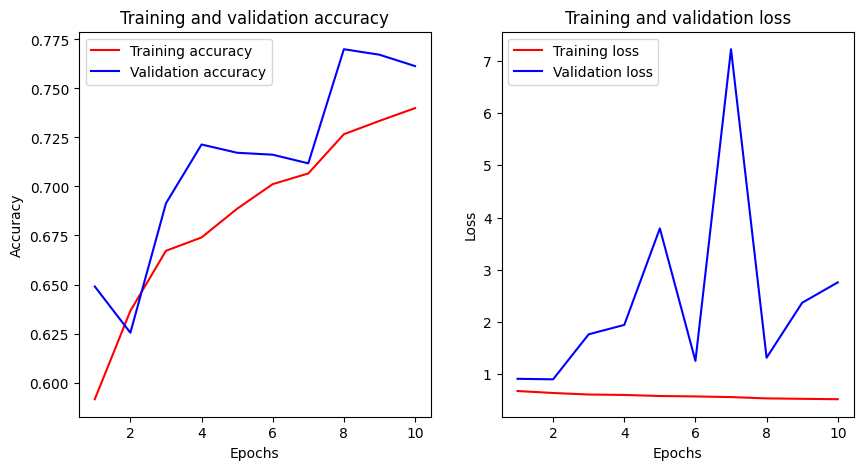

In [94]:
# Train the model and track metrics
model, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(
    model, train_loader, validate_loader, criterion, optimizer, scheduler, num_epochs=num_epochs
)

# Save the model
torch.save(model.state_dict(), "model_cats_vs_dogs.pth")

# Plot training and validation accuracy and loss
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, 'r', label='Training accuracy')
plt.plot(epochs, val_acc_history, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_history, 'r', label='Training loss')
plt.plot(epochs, val_loss_history, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Test the model

In [95]:
test_directory = "data/dogs-vs-cats/test1"
test_filenames = os.listdir(test_directory)
test_df = pd.DataFrame({
    'image_name': test_filenames
})
nb_samples = test_df.shape[0]

# Define a Dataset class for the test data
class TestDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Define the transformation for the test data
test_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create the test dataset and dataloader
test_dataset = TestDataset(test_df, test_directory, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Perform inference
model.eval()
predictions = []

with torch.no_grad():
    for inputs in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

# Map numeric labels to class names
class_labels = {0: 'cat', 1: 'dog'}
test_df['category'] = predictions
test_df['category'] = test_df['category'].map(class_labels)

print(test_df[['image_name', 'category']])

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████| 834/834 [00:21<00:00, 39.01it/s]

      image_name category
0      10395.jpg      cat
1       7766.jpg      dog
2       1798.jpg      dog
3       1679.jpg      cat
4      11670.jpg      dog
...          ...      ...
12495    501.jpg      dog
12496   3166.jpg      dog
12497   3873.jpg      dog
12498   3436.jpg      dog
12499   4302.jpg      dog

[12500 rows x 2 columns]


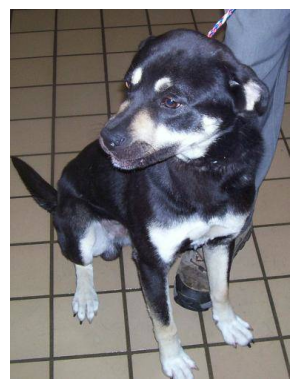

In [97]:
img_path = "data/dogs-vs-cats/test1/7766.jpg"
img = io.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [101]:
# Predict a single image
def predict_single_image(image_path):
    
    transform = transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess the image
    img = Image.open(image_path)
    img = transform(img)  # Apply transformations
    img = img.unsqueeze(0)  # Add batch dimension
    img = img.to(device)  # Move to the same device as the model
    
    # Perform inference
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        output = model(img)
        _, pred = torch.max(output, 1)  # Get the index of the highest probability
    
    # Move the prediction back to CPU and convert to numpy
    pred = pred.cpu().numpy()[0]
    
    # Map numeric labels to class names
    class_labels = {0: 'cat', 1: 'dog'}
    predicted_label = class_labels[pred]
    
    return predicted_label

# Test single image prediction
image_path = "data/NationalGeographic_2572187_square.jpg"
predicted_label = predict_single_image(image_path)
print(f"Predicted label: {predicted_label}")

Predicted label: cat
